Dataset loaded successfully!

--- Data Exploration ---
Dataset shape: (1000, 10)

First 5 rows:
   Year    Country  Avg_Temperature_degC  CO2_Emissions_tons_per_capita  \
0  2006         UK                   8.9                            9.3   
1  2019        USA                  31.0                            4.8   
2  2014     France                  33.9                            2.8   
3  2010  Argentina                   5.9                            1.8   
4  2007    Germany                  26.9                            5.6   

   Sea_Level_Rise_mm  Rainfall_mm  Population  Renewable_Energy_pct  \
0                3.1         1441   530911230                  20.4   
1                4.2         2407   107364344                  49.2   
2                2.2         1241   441101758                  33.3   
3                3.2         1892  1069669579                  23.7   
4                2.4         1743   124079175                  12.5   

   Extreme_Weather_Events 

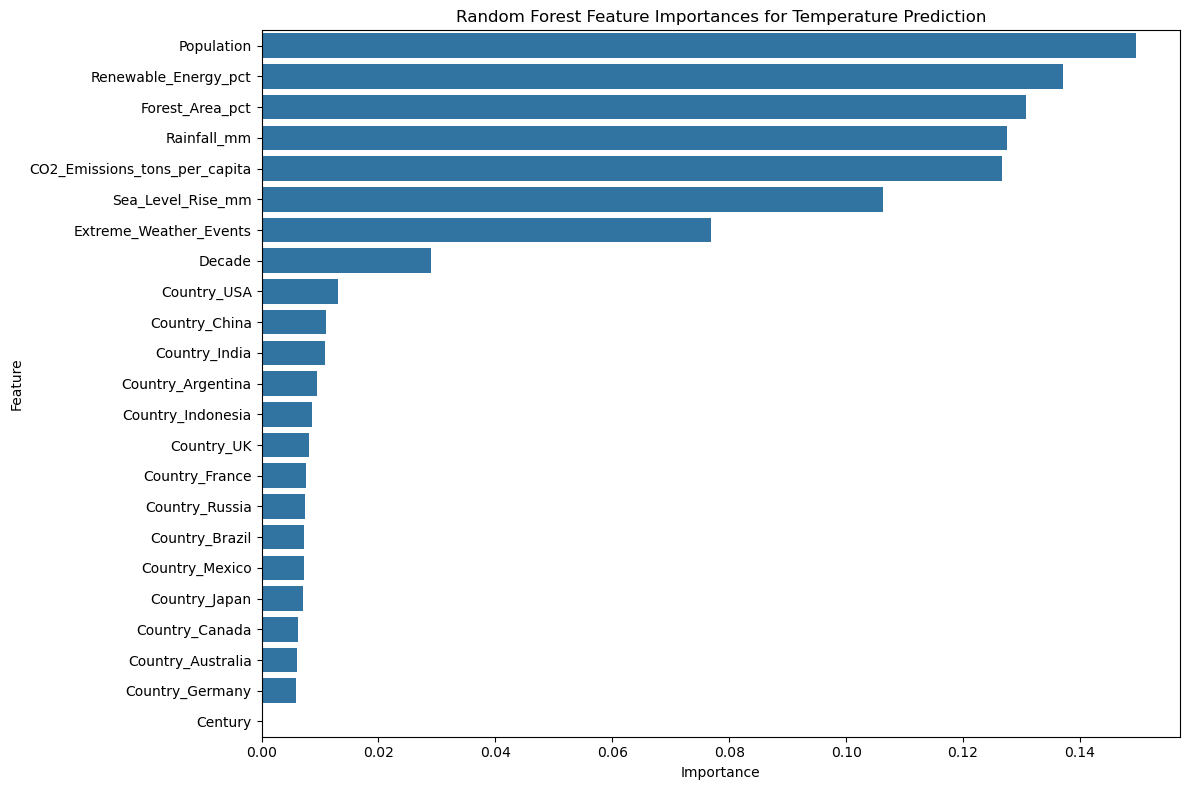

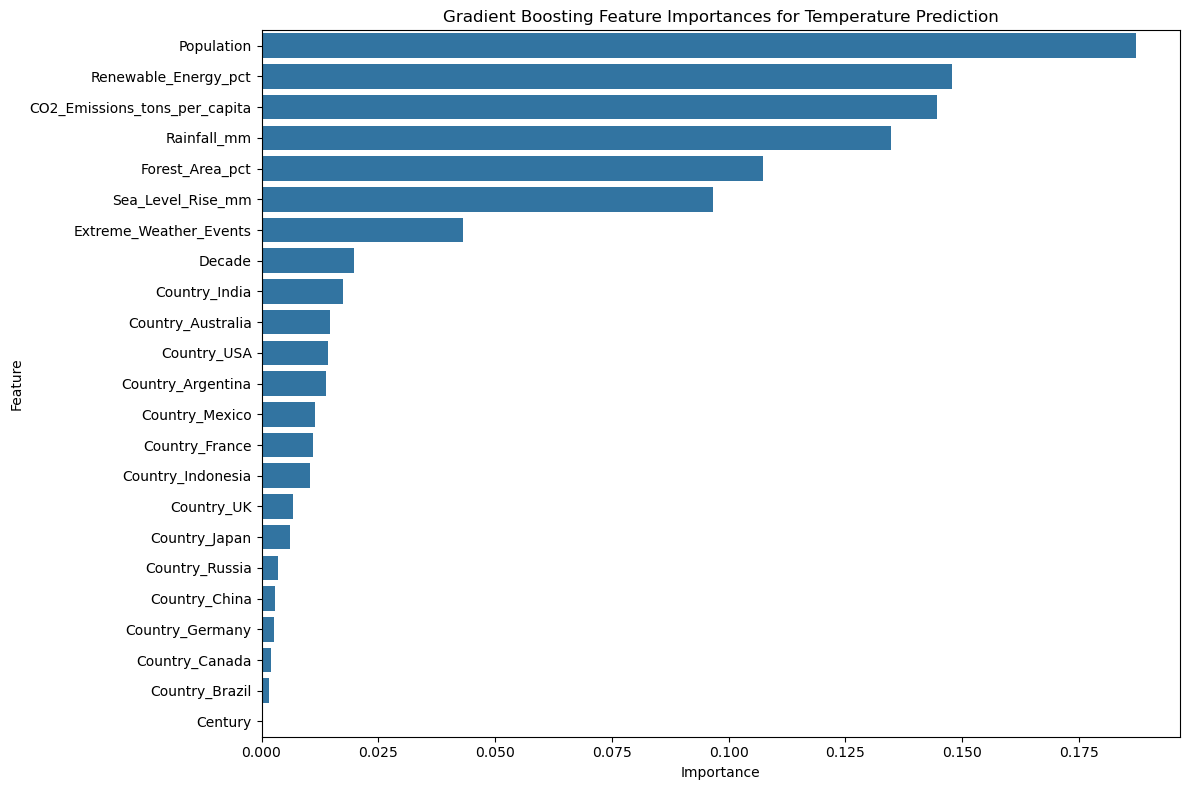

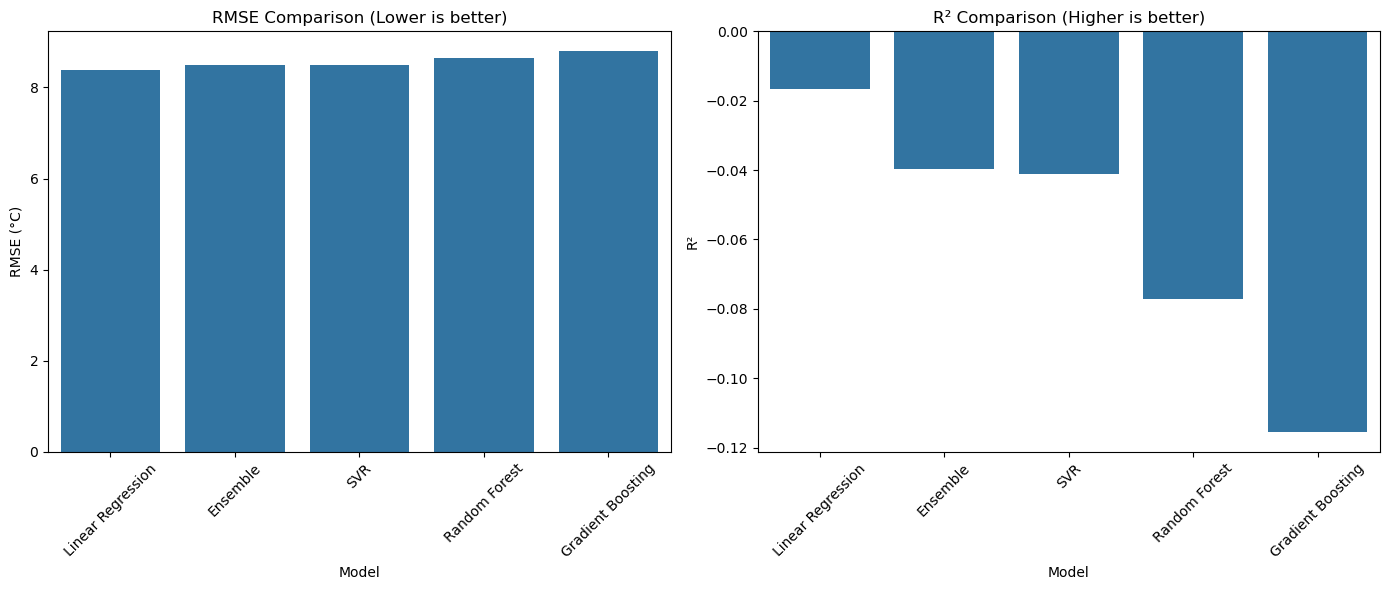

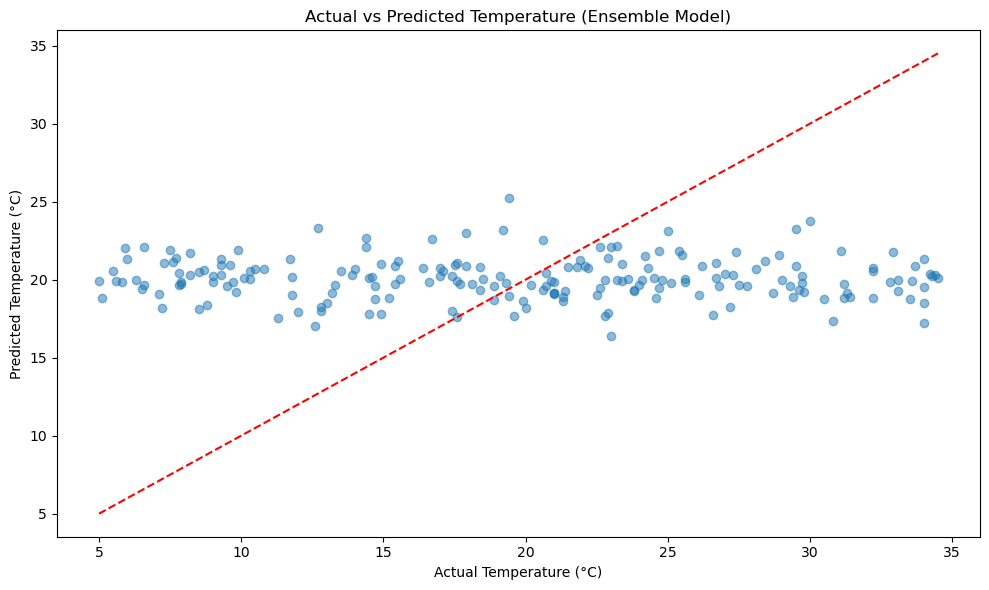

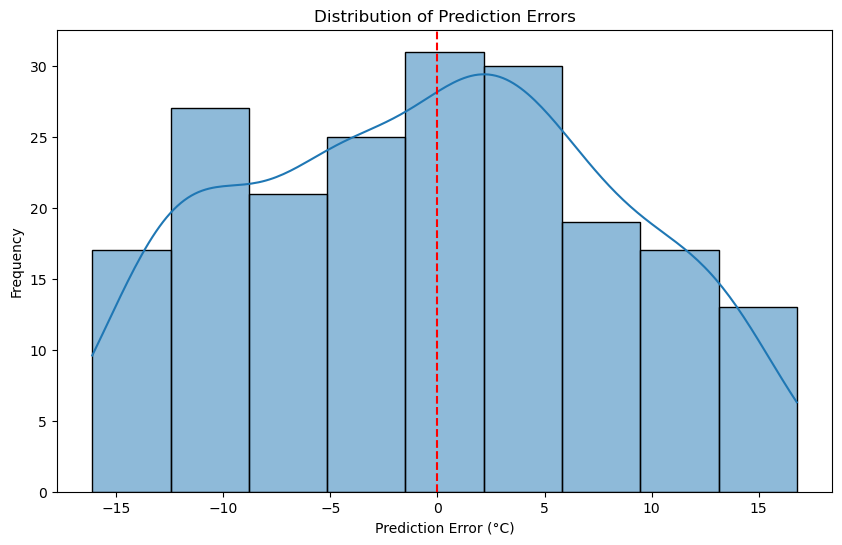

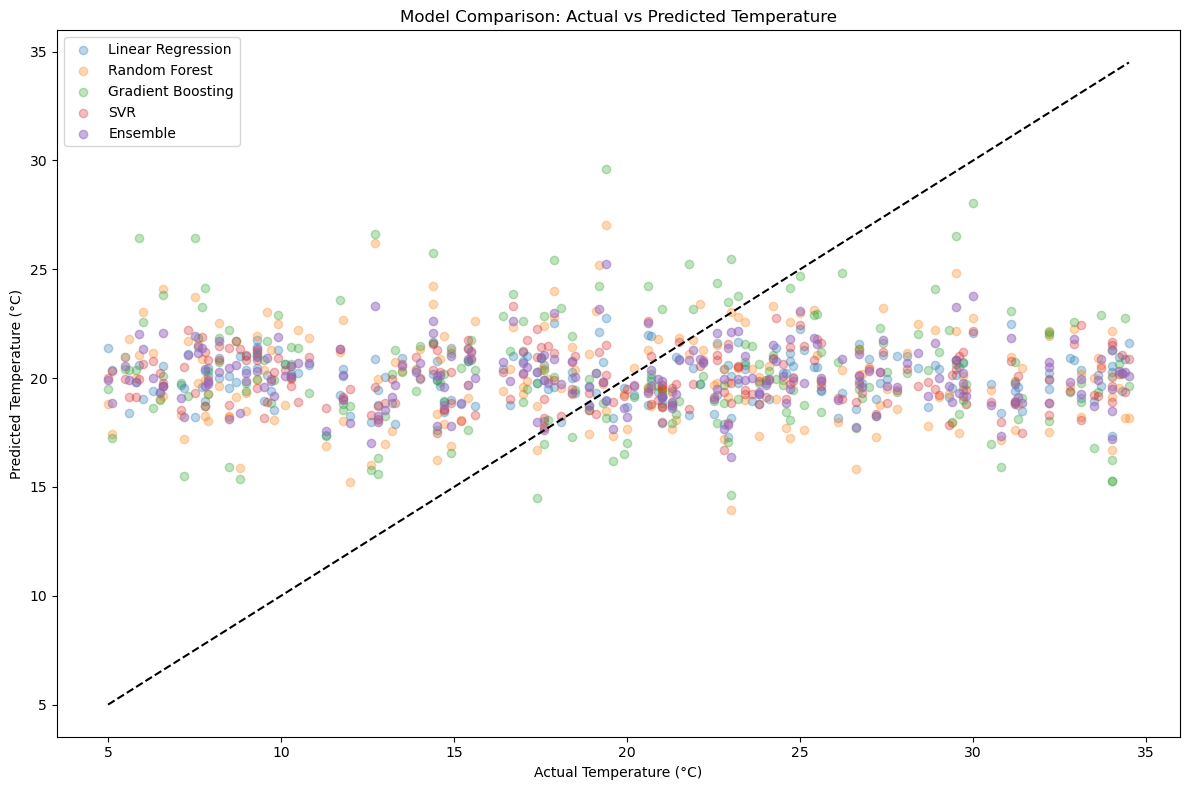

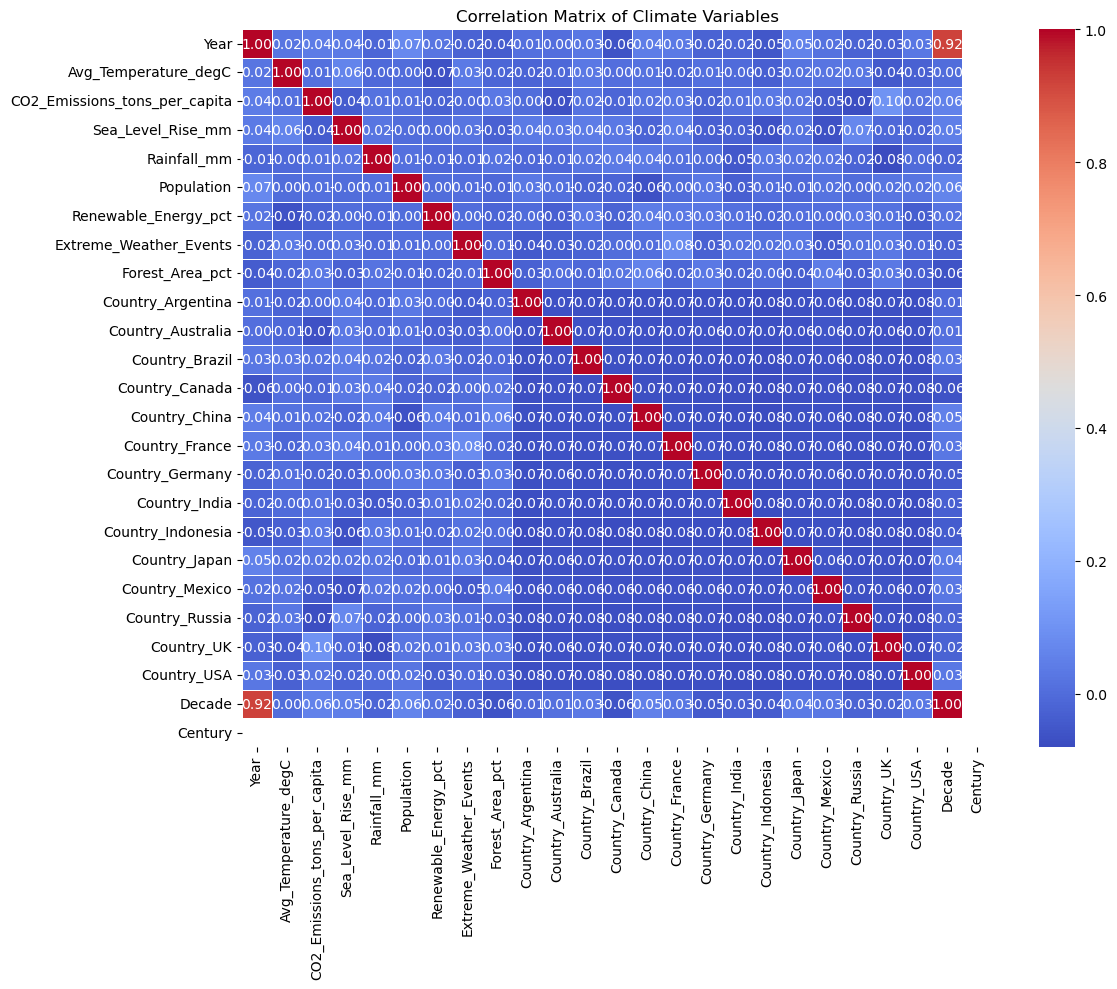

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
try:
    # Attempt to load the data
    df = pd.read_csv('Downloads/temperature.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found. Please download from: https://www.kaggle.com/datasets/adilshamim8/temperature")
    # Exit the script
    import sys
    sys.exit()

# Data Exploration
print("\n--- Data Exploration ---")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# Define target column
target_column = 'Avg_Temperature_degC'

# Check if target column exists
if target_column not in df.columns:
    print(f"Error: Target column '{target_column}' not found in dataset.")
    print("Available columns:", df.columns.tolist())
    import sys
    sys.exit()

print(f"\nUsing '{target_column}' as the target variable")

print("\nDataset information:")
print(df.info())
print("\nStatistical summary:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
missing_values = df.isnull().sum()
print(missing_values)

# Data Preprocessing
print("\n--- Data Preprocessing ---")

# Handle missing values if any
if missing_values.sum() > 0:
    print("Handling missing values...")
    # For numerical columns, fill with median
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns (if any), fill with mode
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    print("Missing values after imputation:")
    print(df.isnull().sum())

# Handle non-numeric features (like Country)
# Convert categorical variables to numeric using one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    print(f"Converting categorical columns to numeric: {categorical_cols}")
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature Engineering
# Check if 'Year' is in the dataset and convert it to a more meaningful feature
if 'Year' in df.columns:
    # Create decade feature
    df['Decade'] = (df['Year'] // 10) * 10
    
    # Create century feature
    df['Century'] = (df['Year'] // 100) + 1
    
    print("Added time-based features: Decade and Century")

# Split features and target
X = df.drop([target_column], axis=1)  # Using the identified target column

# If Year is just an identifier and not a predictor, we might want to drop it
if 'Year' in X.columns:
    # Check correlation with target
    year_corr = df['Year'].corr(df[target_column])
    print(f"Correlation between Year and {target_column}: {year_corr:.4f}")
    
    if abs(year_corr) < 0.1:  # If correlation is low
        print("Dropping 'Year' column as it appears to be just an identifier")
        X = X.drop('Year', axis=1)

y = df[target_column]

print(f"Features ({X.shape[1]}):", X.columns.tolist())
print(f"Target: {target_column}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building
print("\n--- Model Building ---")

# Create individual models for the ensemble
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
svr = SVR(kernel='rbf')

# Train individual models
print("Training individual models...")
lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)
gb.fit(X_train_scaled, y_train)
svr.fit(X_train_scaled, y_train)

# Create an ensemble model using VotingRegressor
ensemble = VotingRegressor(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('gb', gb),
        ('svr', svr)
    ]
)

# Train the ensemble model
print("Training ensemble model...")
ensemble.fit(X_train_scaled, y_train)

# Model Evaluation
print("\n--- Model Evaluation ---")

# Helper function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Training RMSE: {train_rmse:.4f} °C")
    print(f"Testing RMSE: {test_rmse:.4f} °C")
    print(f"Training MAE: {train_mae:.4f} °C")
    print(f"Testing MAE: {test_mae:.4f} °C")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    return test_rmse, test_r2, y_test_pred

# Evaluate individual models
print("Evaluating individual models...")
lr_rmse, lr_r2, lr_pred = evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
rf_rmse, rf_r2, rf_pred = evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")
gb_rmse, gb_r2, gb_pred = evaluate_model(gb, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting")
svr_rmse, svr_r2, svr_pred = evaluate_model(svr, X_train_scaled, X_test_scaled, y_train, y_test, "Support Vector Regression")

# Evaluate ensemble model
print("\nEvaluating ensemble model...")
ensemble_rmse, ensemble_r2, ensemble_pred = evaluate_model(ensemble, X_train_scaled, X_test_scaled, y_train, y_test, "Ensemble Model")

# Feature Importance Analysis (for models that support it)
print("\n--- Feature Importance Analysis ---")

# For Random Forest
if hasattr(rf, 'feature_importances_'):
    print("\nRandom Forest Feature Importances:")
    rf_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(rf_importances)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_importances)
    plt.title('Random Forest Feature Importances for Temperature Prediction')
    plt.tight_layout()
    plt.savefig('rf_feature_importances.png')
    print("Feature importance plot saved as 'rf_feature_importances.png'")

# For Gradient Boosting
if hasattr(gb, 'feature_importances_'):
    print("\nGradient Boosting Feature Importances:")
    gb_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': gb.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(gb_importances)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=gb_importances)
    plt.title('Gradient Boosting Feature Importances for Temperature Prediction')
    plt.tight_layout()
    plt.savefig('gb_feature_importances.png')
    print("Feature importance plot saved as 'gb_feature_importances.png'")

# Compare model performances
print("\n--- Model Performance Comparison ---")
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'SVR', 'Ensemble']
rmse_scores = [lr_rmse, rf_rmse, gb_rmse, svr_rmse, ensemble_rmse]
r2_scores = [lr_r2, rf_r2, gb_r2, svr_r2, ensemble_r2]

# Create a dataframe to store the comparison results
comparison_df = pd.DataFrame({
    'Model': models,
    'RMSE (°C)': rmse_scores,
    'R²': r2_scores
}).sort_values('RMSE (°C)')

print(comparison_df)

# Plot model comparison
plt.figure(figsize=(14, 6))

# RMSE comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE (°C)', data=comparison_df)
plt.title('RMSE Comparison (Lower is better)')
plt.xticks(rotation=45)

# R² comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R²', data=comparison_df)
plt.title('R² Comparison (Higher is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png')
print("Model comparison plot saved as 'model_comparison.png'")

# Visualize actual vs predicted values for the ensemble model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ensemble_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Actual vs Predicted Temperature (Ensemble Model)')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
print("Actual vs Predicted plot saved as 'actual_vs_predicted.png'")

# Plot prediction errors
plt.figure(figsize=(10, 6))
prediction_errors = y_test - ensemble_pred
sns.histplot(prediction_errors, kde=True)
plt.xlabel('Prediction Error (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.savefig('prediction_errors.png')
print("Prediction errors plot saved as 'prediction_errors.png'")

# Compare predictions from all models
plt.figure(figsize=(12, 8))
plt.scatter(y_test, lr_pred, alpha=0.3, label='Linear Regression')
plt.scatter(y_test, rf_pred, alpha=0.3, label='Random Forest')
plt.scatter(y_test, gb_pred, alpha=0.3, label='Gradient Boosting')
plt.scatter(y_test, svr_pred, alpha=0.3, label='SVR')
plt.scatter(y_test, ensemble_pred, alpha=0.5, label='Ensemble')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Model Comparison: Actual vs Predicted Temperature')
plt.legend()
plt.tight_layout()
plt.savefig('model_predictions_comparison.png')
print("Model predictions comparison plot saved as 'model_predictions_comparison.png'")

# Cross-validation for the ensemble model
print("\n--- Cross-Validation Results ---")
cv_scores = cross_val_score(ensemble, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"5-Fold CV RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean():.4f} °C")
print(f"Standard Deviation of CV RMSE: {cv_rmse.std():.4f} °C")

# Relationship between features and temperature
print("\n--- Feature-Target Relationships ---")
top_correlations = df.corr()[target_column].sort_values(ascending=False)
print("Top correlations with temperature:")
print(top_correlations)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Climate Variables')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
print("Correlation matrix saved as 'correlation_matrix.png'")

print("\n--- Summary ---")
print(f"Best performing model: {comparison_df.iloc[0]['Model']} with RMSE = {comparison_df.iloc[0]['RMSE (°C)']:.4f} °C")

# Analyze which model contributes most to the ensemble
if comparison_df.iloc[0]['Model'] == 'Ensemble':
    print("\nThe ensemble model outperforms individual models by combining their strengths.")
else:
    print(f"\nNote: The {comparison_df.iloc[0]['Model']} outperforms the ensemble model.")
    print("This suggests that for this specific dataset, this single model captures the patterns most effectively.")

print("\nKey insights from feature importance analysis:")
if 'rf_importances' in locals():
    top_features = rf_importances.head(3)['Feature'].tolist()
    print(f"Most important features according to Random Forest: {', '.join(top_features)}")

print("\nRecommendations:")
print("1. Consider using the best performing model for temperature predictions.")
print("2. Focus on the most important features identified for data collection and monitoring.")
print("3. For future work, consider adding temporal analysis to track temperature trends over time.")
print("4. Experiment with hyperparameter tuning to potentially improve model performance.")